# General pipeline for project 1
This is an example pipeline showing you how to  
(1) Load the provided data;  
(2) Train models on the train set, and use the validation set to evaluate your model performance;  
(3) Generate predictions (pred.csv) on the test set, which is ready for submission.

In [ ]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import tensorflow.keras as K
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# just to ignore the matplotlib warnings to make the plots look better
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# if you use Google Colab, un-comment this cell, modify `path_to_data` if needed, and run to mount data to `data`
# from google.colab import drive
# drive.mount('/content/drive')

# path_to_data = '/content/drive/MyDrive/HKUST stuff/COMP4332_Project1/data'
# !rm -f data
# !ln -s '/content/drive/MyDrive/HKUST stuff/COMP4332_Project1/data' data

### (1) Loading data
The following code shows how to load the datasets for this project.  
Among which, we do not release the labels (the "stars" column) for the test set. You may evaluate your trained model on the validation set instead.

However, your submitted predictions (``pred.csv``) should be generated on the test set.

In [ ]:
def load_data(split_name='train', columns=['text', 'stars']):   # remove folder = "data"
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{split_name}.csv')    #remove {folder}/
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{split_name}.csv')     #remove {folder}/
        return df

In [ ]:
train_df = load_data('train', columns=['text', 'stars'])
valid_df = load_data('valid', columns=['text', 'stars'])
# the test set labels (the 'stars' column) are not available! So the following code will instead return all columns
test_df = load_data('test', columns=['text', 'stars'])

select [text, stars] columns from the train split
Success
select [text, stars] columns from the valid split
Success
select [text, stars] columns from the test split
Failed loading specified columns... Returning all columns from the test split


In [ ]:
# test_df.columns
# print(train_df.columns)
# print(valid_df.columns)
# print(test_df.columns)
test_df

,business_id,cool,date,funny,review_id,text,useful,user_id
0,V-qDa2kr5qWdhs7PU-l-3Q,0,2013-05-29,0,fBHWLNEJmhk6AkzmfLwWcw,Would like to give this more stars - usually I...,1,1pigoFijaHVWGrQl1_tYjw
1,C1zlvNlxlGZB8g0162QslQ,0,2012-03-02 15:51:49,0,ldEQ02aP1OeSa5N2beseNg,My wife and I took some friends here after din...,0,BKWPuPZFcGmgjRFRzoq1pw
2,0FOON_PNvG0ZxIZh6Jcv2A,0,2013-09-24 20:31:37,0,0oGr6v9VjtRsRsROGMoWTA,My husband and I had lunch here for the first ...,0,BYVYXKqNs-vv-N1ZhRMs0g
3,r49iBfbnfoK7yt4rdsL_7g,0,2018-10-20 01:34:08,0,eg5eJ5HmqXuzkxucnKvMTw,I love coming here with my friends! Great for ...,2,dpzmyNglDMeTgV3T5ylUSQ
4,xnLNPkL7bbdhD842T4oPqg,0,2016-09-25,1,BNDAe34Mxj--Brkzcfi4QA,Make sure that you double check how much these...,1,yk9wx31bfMEe_IXB8Q-ylA
...,...,...,...,...,...,...,...,...
3995,x_0Vf8AVBk_auLnNHRjoVA,2,2013-05-18 03:06:21,0,s7FLCfjgopRM6olA1NSccg,We live nearby and have stopped by this McDona...,0,Nf3VduiXhQVZRvM2GiXi-w
3996,KAJAsjVhYUPb6b_yodVqvA,0,2018-05-06 05:33:47,0,oJUnsu4PpTZz-kCE88-9uQ,It was boring as ever! All Spanish music so I ...,0,T3hk43jr0t7ZK8RPmce4sQ
3997,EnKpL0rRg1MTTKncmxbnMA,0,2012-03-21 20:49:25,0,celcHgmV26VvtzGdUFsR5w,"Was a long time customer, I was entertaining c...",1,WFWzzvWM45zTx-EShrVVxw
3998,-NR4KqS6lHseNvJ-GFzfMA,2,2016-08-14,1,69yY48SDj-UDCKlGgn-nqg,I really like this place! I like how you can t...,2,SS3sFA9ksCT9bjocM3Wbug


In [ ]:
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()

def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    return [ps.stem(token) for token in tokens]

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### (2) Training and validating 
The following example shows you how to train your model using the train set, and evaluate on the validation set.  
As an example, we only use the text data for training. Feel free to use other columns in your implementation.  

The model performance on the validation set can be roughly regarded as your models final performance, so we can use it to search for optimal hyper-parameters.

In [ ]:
#--------------------------------------------------------------------------------------------------------------------

In [ ]:
# Prepare the data.
# As an example, we only use the text data. 
x_train = train_df['text']
y_train = train_df['stars']
#cool_train = train_df['cool']
#funny_train = train_df['funny']
#useful_train = train_df['useful']
  
x_valid = valid_df['text']
y_valid = valid_df['stars']
#cool_valid = valid_df['cool']
#funny_valid = valid_df['funny']
#useful_valid = valid_df['useful']

x_test = test_df['text']
#cool_test = test_df['cool']
#funny_test = test_df['funny']
#useful_test = test_df['useful']

In [ ]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out
    :param max_size: the max size of feature dict
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

In [ ]:
def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

In [ ]:
def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results

In [ ]:
def build_classifier(input_size, output_size, learning_rate=0.1,
                     l2_reg=0.0,
                     loss="categorical_crossentropy",
                     optimizer="SGD",
                     metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param learning_rate: the learning rate for the optimizer
    :param l2_reg: the weight for the L2 regularizer
    :param loss: the training loss
    :param optimizer: the optimizer
    :param metric: the metric
    return a 1-layer perceptron,
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    model = Sequential()
    
    # the projection layer
    # o = w.T x + b
    # w is kernel, b is bias
    model.add(Dense(output_size,
                    activation="softmax",
                    input_dim=input_size,
                    kernel_initializer=K.initializers.he_normal(seed=0),
                    bias_initializer="zeros",
                    kernel_regularizer=K.regularizers.l2(l2_reg)))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = K.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optimizer = K.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optimizer = K.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model


In [ ]:
print(len(x_train))

18000


In [ ]:
nltk.download('punkt')

train_tokens = [tokenize(text) for text in x_train]
valid_tokens = [tokenize(text) for text in x_valid]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]

#train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
#valid_2_gram = [n_gram(tokens, 2) for tokens in valid_stemmed]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]    #final stemmed
valid_stemmed = [filter_stopwords(tokens) for tokens in valid_stemmed]    #final stemmed

# build the feature list
train_feats = list()
for i in range(len(x_train)):
    # concatenate the stemmed token list and the 2_gram list together
    train_feats.append(train_stemmed[i])
valid_feats = list()
for i in range(len(x_valid)):
    # concatenate the stemmed token list and the 2_gram list together
    valid_feats.append(valid_stemmed[i])


# build the feature dict
feats = set()
# collect all features
for f in train_feats:     # in train_feats -> train_stemmed
    feats.update(f)

print("Size of features:", len(feats))
# build a mapping from features to indices
feats_dict = get_feats_dict(chain.from_iterable(train_stemmed),min_freq=1, max_freq=20000)   #original min = 5 ->min_freq=100, max_freq=20000

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack([get_onehot_vector( f, feats_dict) for f in train_feats]) # train_feats -> train_stemmed
valid_feats_matrix = np.vstack([get_onehot_vector( f, feats_dict) for f in valid_feats])  # valid_feats -> valid_stemmed



# convert labels to label_matrix
num_classes = max(y_train)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = tf.keras.utils.to_categorical(y_train-1, num_classes=num_classes)
valid_label_matrix = tf.keras.utils.to_categorical(y_valid-1, num_classes=num_classes)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Size of features: 32076
Size of features: 32072


In [ ]:
test_token = [tokenize(text) for text in x_test]
test_stemmed = [stem(tokens) for tokens in test_token]
test_stemmed = [filter_stopwords(tokens) for tokens in test_stemmed]
test_feats_matrix = np.vstack([get_onehot_vector( f, feats_dict) for f in test_stemmed])

In [ ]:
# build the classifier  Fit the data 
model = build_classifier(len(feats_dict), num_classes, learning_rate=0.1)

NameError: ignored

In [ ]:
'''from collections import Counter
feat_cnt = Counter()
for feat in train_stemmed:
    feat_cnt.update(feat)
feat_cnt.most_common(10)'''

[('.', 120000),
 (',', 67758),
 ('wa', 37148),
 ('!', 25718),
 ('thi', 16394),
 ("n't", 13361),
 ("'s", 11397),
 ('place', 9842),
 ('food', 9256),
 ('good', 9034)]

In [ ]:
#print(feats)

In [ ]:
history = model.fit(train_feats_matrix, train_label_matrix, validation_data=(valid_feats_matrix, valid_label_matrix), epochs=20, batch_size=100) 

Epoch 1/20
180/180 [==============================] - 5s 27ms/step - loss: 1.4700 - accuracy: 0.4331 - val_loss: 1.3914 - val_accuracy: 0.4475
Epoch 2/20
180/180 [==============================] - 3s 19ms/step - loss: 1.3443 - accuracy: 0.4584 - val_loss: 1.3057 - val_accuracy: 0.4825
Epoch 3/20
180/180 [==============================] - 3s 19ms/step - loss: 1.2715 - accuracy: 0.4941 - val_loss: 1.2463 - val_accuracy: 0.5205
Epoch 4/20
180/180 [==============================] - 4s 23ms/step - loss: 1.2193 - accuracy: 0.5184 - val_loss: 1.2025 - val_accuracy: 0.5305
Epoch 5/20
180/180 [==============================] - 4s 20ms/step - loss: 1.1796 - accuracy: 0.5312 - val_loss: 1.1690 - val_accuracy: 0.5455
Epoch 6/20
180/180 [==============================] - 3s 18ms/step - loss: 1.1481 - accuracy: 0.5450 - val_loss: 1.1419 - val_accuracy: 0.5555
Epoch 7/20
180/180 [==============================] - 3s 19ms/step - loss: 1.1225 - accuracy: 0.5533 - val_loss: 1.1200 - val_accuracy: 0.5645

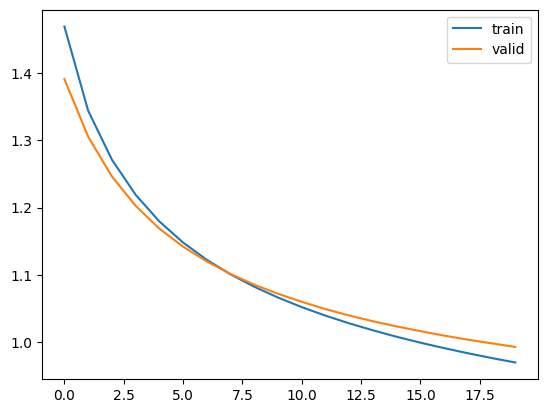

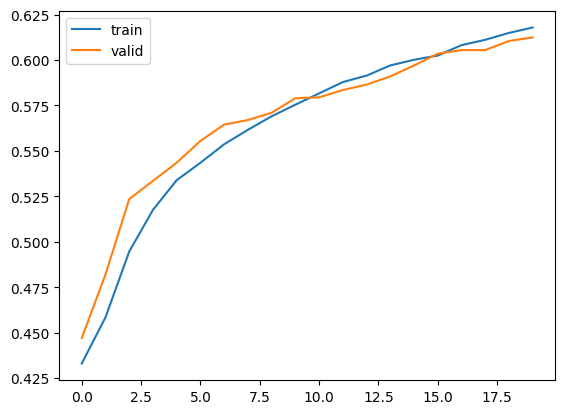

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label='valid')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label='valid')
plt.legend()
plt.show()

In [ ]:
model.evaluate(valid_feats_matrix, valid_label_matrix)

63/63 [==============================] - 0s 3ms/step - loss: 0.9931 - accuracy: 0.6125


[0.9930862784385681, 0.612500011920929]

In [ ]:
valid_pred = np.argmax(model.predict(valid_feats_matrix), axis=-1)

63/63 [==============================] - 0s 3ms/step


In [ ]:
valid_pred += 1

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(classification_report(y_valid, valid_pred))
print("\n\n")
print(confusion_matrix(y_valid, valid_pred))
print('accuracy', np.mean(y_valid == valid_pred))

              precision    recall  f1-score   support

           1       0.68      0.75      0.71       292
           2       0.57      0.07      0.13       163
           3       0.43      0.10      0.17       232
           4       0.44      0.38      0.41       421
           5       0.65      0.91      0.76       892

    accuracy                           0.61      2000
   macro avg       0.56      0.44      0.44      2000
weighted avg       0.58      0.61      0.56      2000




[[219   4   7   8  54]
 [ 57  12   9  36  49]
 [ 25   2  24  94  87]
 [ 11   1  11 162 236]
 [ 11   2   5  66 808]]
accuracy 0.6125


In [ ]:
model2 = build_classifier(len(feats_dict), num_classes, learning_rate=0.1, l2_reg=0.01)
history2 = model2.fit(train_feats_matrix, train_label_matrix, validation_data=(valid_feats_matrix, valid_label_matrix), epochs=20, batch_size=100)
plt.figure()
plt.plot(history2.history["loss"], label="train")
plt.plot(history2.history["val_loss"], label='valid')
plt.legend()
plt.show()

plt.figure()
plt.plot(history2.history["accuracy"], label="train")
plt.plot(history2.history["val_accuracy"], label='valid')
plt.legend()
plt.show()

In [ ]:
valid_pred2 = np.argmax(model2.predict(valid_feats_matrix), axis=-1)
valid_pred2 += 1
print(classification_report(y_valid, valid_pred2))
print("\n\n")
print(confusion_matrix(y_valid, valid_pred2))
print('accuracy', np.mean(y_valid == valid_pred2))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           1       0.67      0.67      0.67       292
           2       0.50      0.02      0.05       163
           3       0.41      0.06      0.11       232
           4       0.42      0.33      0.37       421
           5       0.62      0.92      0.74       892

    accuracy                           0.59      2000
   macro avg       0.52      0.40      0.39      2000
weighted avg       0.55      0.59      0.52      2000




[[196   2   5   8  81]
 [ 58   4   6  36  59]
 [ 21   0  14  93 104]
 [  9   0   6 140 266]
 [  8   2   3  58 821]]
accuracy 0.5875


In [ ]:
!pip install keras-layer-normalization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate
from keras_layer_normalization import LayerNormalization

def build_MLP(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,     #L2 = 0.0
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a multi-layer perceptron,
    # activation
    # dropout document: https://keras.io/layers/core/#dropout
    # batch normalization document: https://keras.io/layers/normalization/
    # layer normalization: https://github.com/CyberZHG/keras-layer-normalization
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    model = Sequential()
    
    if num_layers == 1:
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=input_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros",
                        kernel_regularizer=keras.regularizers.l2(l2_reg)))
    else:
        for i in range(num_layers-1):
            
            if i == 0:
                # first layer: input -> hidden
                model.add(Dense(hidden_size,
                        input_dim=input_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros",
                        kernel_regularizer=keras.regularizers.l2(l2_reg)))
            else:
                # hidden layers: hidden -> hidden
                model.add(Dense(hidden_size,
                        input_dim=hidden_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros",
                        kernel_regularizer=keras.regularizers.l2(l2_reg)))
            # add layer_norm
            if layer_norm:
                model.add(LayerNormalization())
            # add batch_norm
            if batch_norm:
                model.add(BatchNormalization())
            # add activation
            model.add(Activation(activation))
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                model.add(dropout_rate, seed = 0)

        
        # last layer: hidden -> class
        model.add(Dense(output_size,
                        activation = 'softmax',
                        input_dim=hidden_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros"))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model


In [ ]:
model_MLP = build_MLP(input_size=len(feats_dict), output_size=num_classes,
              num_layers=3, hidden_size=400, activation="relu",
              l2_reg=0.005, learning_rate=0.1)

In [ ]:
his3 = model_MLP.fit(train_feats_matrix, train_label_matrix, validation_data=(valid_feats_matrix, valid_label_matrix), epochs=5, batch_size=100)

Epoch 1/5
180/180 [==============================] - 46s 248ms/step - loss: 7.8336 - accuracy: 0.5594 - val_loss: 6.5194 - val_accuracy: 0.6385
Epoch 2/5
180/180 [==============================] - 33s 180ms/step - loss: 5.5978 - accuracy: 0.6523 - val_loss: 4.8103 - val_accuracy: 0.6400
Epoch 3/5
180/180 [==============================] - 32s 180ms/step - loss: 4.1294 - accuracy: 0.6841 - val_loss: 3.6430 - val_accuracy: 0.6450
Epoch 4/5
180/180 [==============================] - 33s 184ms/step - loss: 3.1224 - accuracy: 0.6988 - val_loss: 2.8480 - val_accuracy: 0.6440
Epoch 5/5
180/180 [==============================] - 34s 187ms/step - loss: 2.4214 - accuracy: 0.7111 - val_loss: 2.2803 - val_accuracy: 0.6405


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
valid_pred3 = np.argmax(model_MLP.predict(valid_feats_matrix), axis=-1)
valid_pred3 += 1
print(classification_report(y_valid, valid_pred3))
print("\n\n")
print(confusion_matrix(y_valid, valid_pred3))
print('accuracy', np.mean(y_valid == valid_pred3))

63/63 [==============================] - 3s 39ms/step
              precision    recall  f1-score   support

           1       0.72      0.79      0.75       292
           2       0.47      0.26      0.34       163
           3       0.41      0.34      0.37       232
           4       0.45      0.52      0.48       421
           5       0.79      0.79      0.79       892

    accuracy                           0.64      2000
   macro avg       0.56      0.54      0.55      2000
weighted avg       0.63      0.64      0.63      2000




[[231  24   8  11  18]
 [ 49  43  46  18   7]
 [ 20  17  79  88  28]
 [  7   7  47 219 141]
 [ 16   1  14 152 709]]
accuracy 0.6405


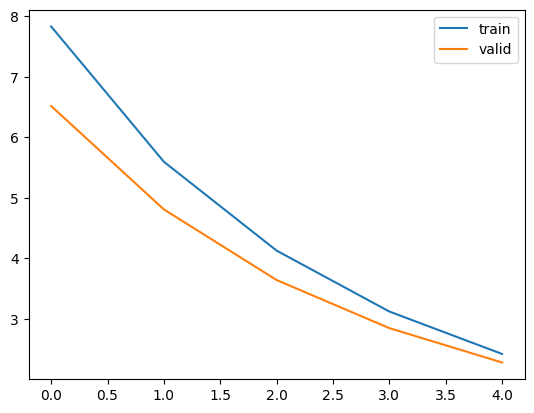

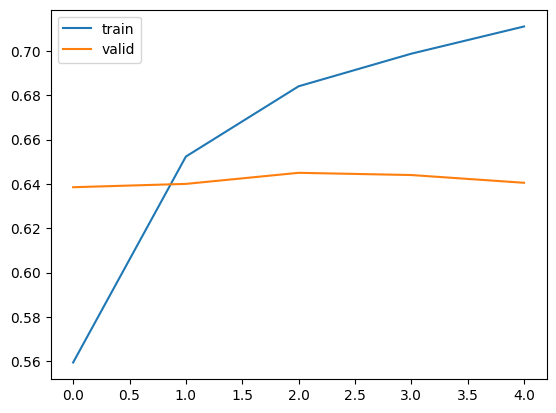

In [ ]:
plt.figure()
plt.plot(his3.history["loss"], label="train")
plt.plot(his3.history["val_loss"], label='valid')
plt.legend()
plt.show()

plt.figure()
plt.plot(his3.history["accuracy"], label="train")
plt.plot(his3.history["val_accuracy"], label='valid')
plt.legend()
plt.show()

In [ ]:
pred = np.argmax(model_MLP.predict(test_feats_matrix), axis=-1)
pred += 1

125/125 [==============================] - 3s 24ms/step


 You can use the valid data to choose the hyperparameters.
As an example, you can decide which value of C (1 or 100) is better by evaluating on the valid data.

In [ ]:
pred

array([3, 5, 5, ..., 1, 1, 1])

In [ ]:
pred_df = pd.DataFrame({'stars': pred, 'review_id': test_df['review_id']})
pred_df.to_csv('pred.csv', index=False)

In [ ]:
# build the first linear model with TFIDF feature
'''tfidf = TfidfVectorizer()
lr1 = LogisticRegression(C=100)
steps = [('tfidf', tfidf),('lr', lr1)]
pipe1 = Pipeline(steps)'''

NameError: ignored

In [ ]:
# train the first model
'''pipe1.fit(x_train, y_train)'''

In [ ]:
# validate on the validation set
'''y_pred = pipe1.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))'''

In [ ]:
# build the second linear model with TFIDF feature
'''tfidf = TfidfVectorizer()
lr2 = LogisticRegression(C=1)
steps = [('tfidf', tfidf),('lr', lr2)]
pipe2 = Pipeline(steps)'''

In [ ]:
# train the second model
'''pipe2.fit(x_train, y_train)'''

In [ ]:
# validate on the validation set
'''y_pred = pipe2.predict(x_valid)
print(classification_report(y_valid, y_pred))
print("\n\n")
print(confusion_matrix(y_valid, y_pred))
print('accuracy', np.mean(y_valid == y_pred))'''

 We find the second model (pipe2) has higher accuracy, then we use the second model to make predictions on test data. In practice, you may not only focus on the accuracy, but also other metrics (precision, recall, f1), since the label distribution is not always balanced.

### (3) Generate predictions on the test set

In [ ]:
'''predict_test = pipe2.predict(x_test)'''

In [ ]:
'''predict_test'''

In [ ]:
# save your model predictions
'''pred_df = pd.DataFrame({'stars': predict_test, 'review_id': test_df['review_id']})
pred_df.to_csv('pred.csv', index=False)'''

 Then you may (download and) submit the predictions `pred.csv` on the test set. 

In [ ]:
'''import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers


def build_classifier(input_size, output_size, learning_rate=0.1):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param learning_rate: the learning rate for SGD
    return a 1-layer perceptron,
    """
    model = Sequential()
    
    # add 1 layer with softmax activation
    # you should specify the output size, the input_size, and the activation function
    model.add(Dense(output_size, activation="softmax", input_dim=input_size, kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), bias_regularizer=regularizers.L2(1e-4),))
    
    # set the loss as categorical_crossentropy, the metric as accuracy, and the optimizer as SGD
    model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=learning_rate), metrics=['accuracy'])
    
    return model'''